In [65]:
# !pip install fbprophet
# !pip install prophet
import numpy as np
import pandas as pd
from prophet import Prophet

In [43]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# 파일경로지정
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')

# Dataset
https://www.kaggle.com/datasets/neuromusic/avocado-prices

# 1 데이터 가져오기

아보카도 판매데이터셋을 가져온다.

* 날짜
* 평균가격
* 일자 별 판매개수
* 아보카도 종류 4046(작거나 중간), 4225,4770 등

## 2. 데이터셋의 구성요소 확인
평균가격과 분포도 확인

In [45]:
df=pd.read_csv('/content/avocado.csv')
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [46]:
# 데이터셋의 대략적인 개요 출력(분포도)
df.describe()

# 아보카도 가격
# 평균 : $1.40
# 최대 : $3.25
# 최소 : $0.44

,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,24.232232,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,15.481045,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.000000,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,10.000000,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,24.000000,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,38.000000,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,52.000000,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [47]:
# type 별로 아보카도 구분해봄
# conventional : 일반적인 아보카도
# organic :유기농 아보카도


df.groupby('type').mean()

<ipython-input-47-a49a5e0665fd>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('type').mean()


,Unnamed: 0,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
type,,,,,,,,,,,
conventional,24.236686,1.158040,1.653213e+06,578611.649925,574805.318859,45405.796798,454390.130901,346721.795885,101457.698855,6210.635065,2016.147929
organic,24.227776,1.653999,4.781121e+04,7311.281600,15411.857724,266.254582,24817.654696,17613.474543,7202.982659,1.197164,2016.147868


In [48]:
#미국의 Conventional 아보카도만 전처리
df=df.loc[(df.type=='conventional') & (df.region=='TotalUS')]

## 날짜 string -> 날짜 형식으로 변환
df['Date']=pd.to_datetime(df['Date'])

#data 변수에 날짜와 가격데이터만 저장 (날짜에 따른 가격 예측을 위함)
data =df[['Date','AveragePrice']].reset_index(drop=True)
data=data.rename(columns={'Date':'ds', 'AveragePrice':'y'}) # 컬럼명 지정
data.head()

<ipython-input-48-6ef8ca53bd3c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date']=pd.to_datetime(df['Date'])


,ds,y
0,2015-12-27,0.95
1,2015-12-20,0.98
2,2015-12-13,0.93
3,2015-12-06,0.89
4,2015-11-29,0.99


<Axes: xlabel='ds'>

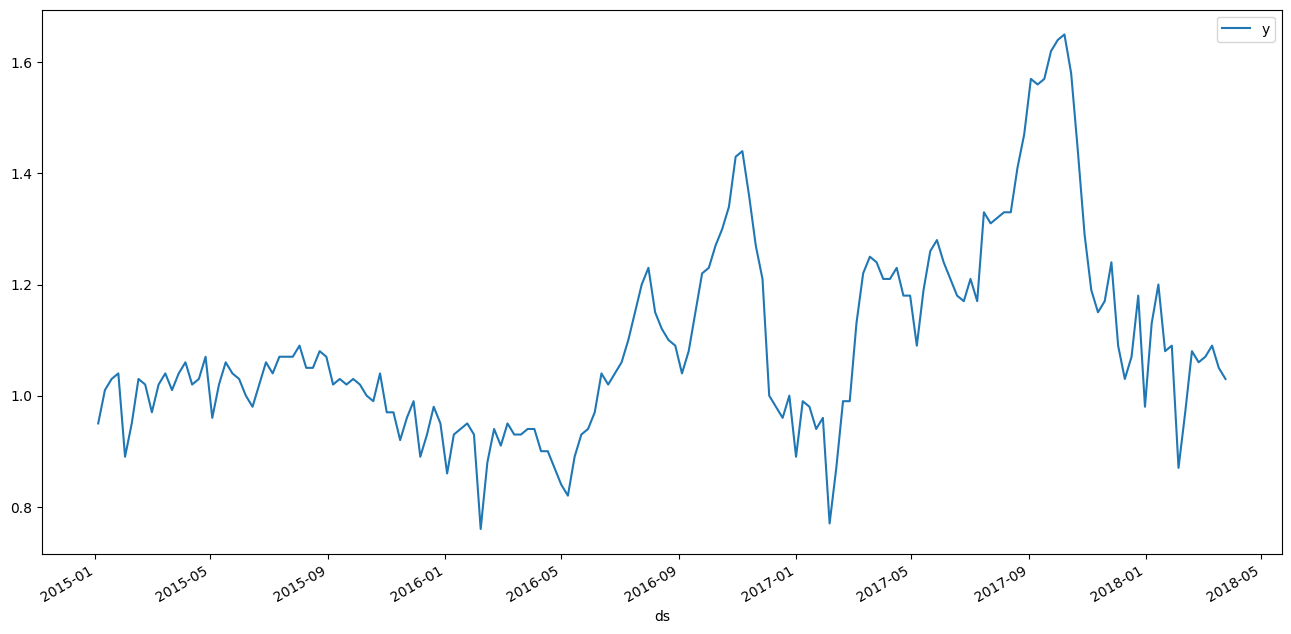

In [49]:
# 가격 변동상활 그래프로 확인
data.plot(x='ds', y='y', figsize=(16,8))

# Fit
https://facebook.github.io/prophet/docs/quick_start.html

In [68]:
model=Prophet()
model.fit(data) #학습

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxn83esf4/2s9eziie.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxn83esf4/_a49xmhd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97134', 'data', 'file=/tmp/tmpxn83esf4/2s9eziie.json', 'init=/tmp/tmpxn83esf4/_a49xmhd.json', 'output', 'file=/tmp/tmpxn83esf4/prophet_modelvaa_gogc/prophet_model-20230627090812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:08:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:08:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Predict


In [77]:
#앞으로의 1년 예측
future=model.make_future_dataframe(periods=365)
# future.tail()

#마지막 5개데이터만 확인
forecast=model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
529,2019-03-21,1.206770,1.012874,1.280096,1.144531,1.276350,-0.062245,-0.062245,-0.062245,-0.062245,-0.062245,-0.062245,0.0,0.0,0.0,1.144525
530,2019-03-22,1.206723,1.021061,1.277319,1.144281,1.276324,-0.060702,-0.060702,-0.060702,-0.060702,-0.060702,-0.060702,0.0,0.0,0.0,1.146021
531,2019-03-23,1.206675,1.020947,1.276303,1.144032,1.276328,-0.058670,-0.058670,-0.058670,-0.058670,-0.058670,-0.058670,0.0,0.0,0.0,1.148005
532,2019-03-24,1.206627,1.027048,1.281566,1.143783,1.276633,-0.056166,-0.056166,-0.056166,-0.056166,-0.056166,-0.056166,0.0,0.0,0.0,1.150462
533,2019-03-25,1.206580,1.025405,1.280221,1.143408,1.276804,-0.053221,-0.053221,-0.053221,-0.053221,-0.053221,-0.053221,0.0,0.0,0.0,1.153358


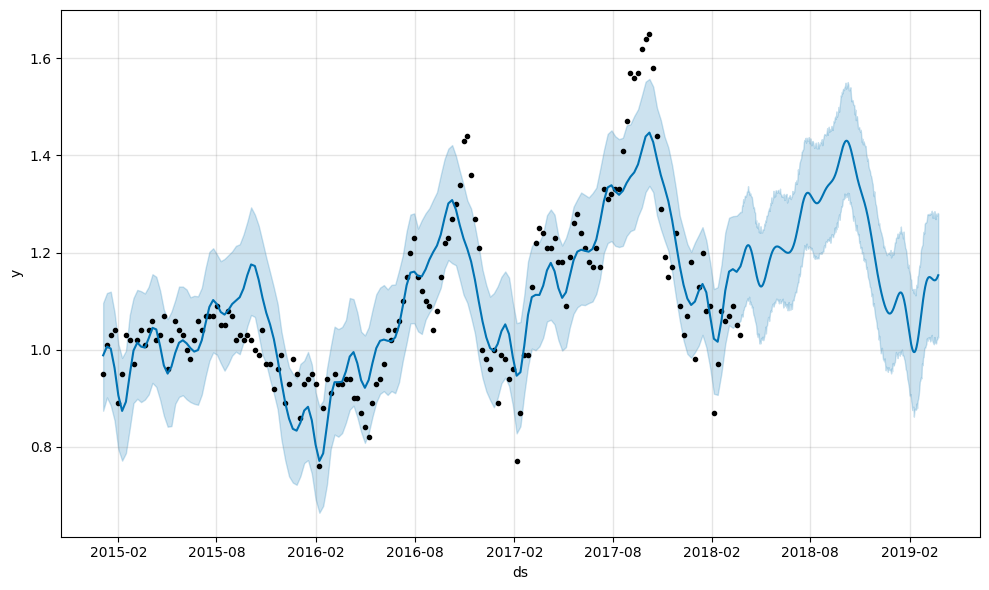

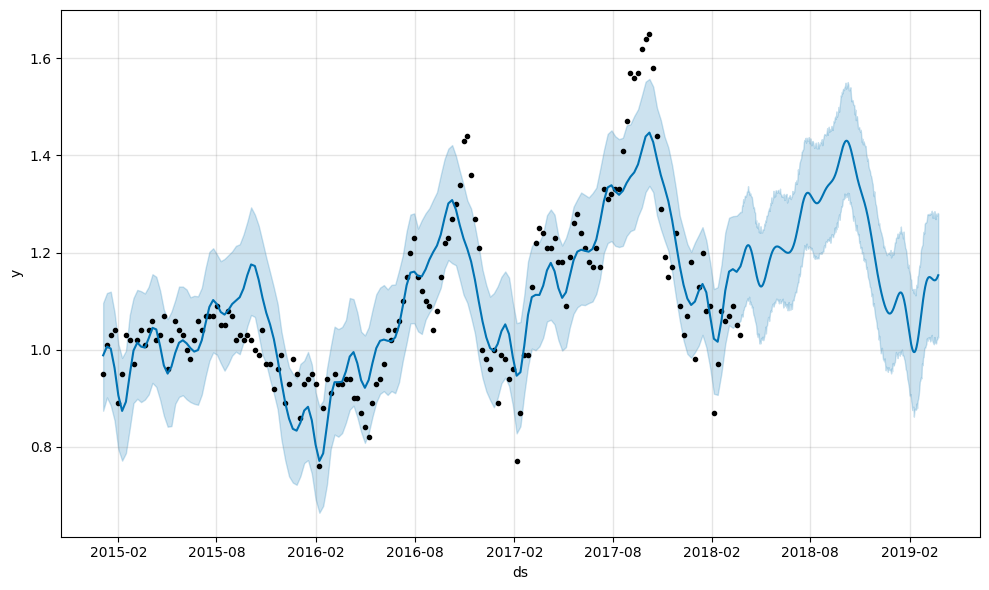

In [78]:
model.plot(forecast)

#. :아보카도 가격
# skyblue : 트렌트
# .이 없는 부분 : 예측한 내용

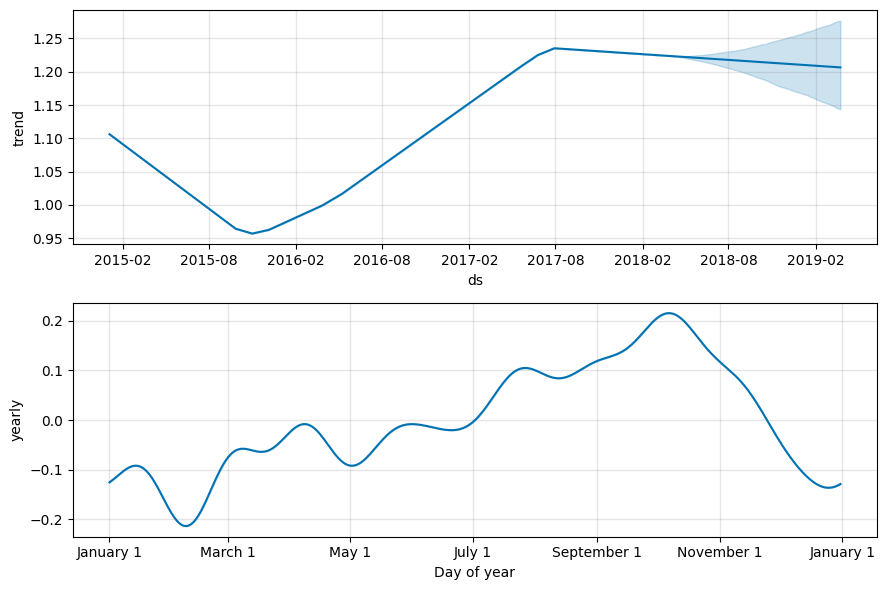

In [79]:
#예측에 영향을 미친 요소들
# trend, yearly(연간 가격 변동 -> 이런 패턴이 있다)
fig2=model.plot_components(forecast)